Phase 4 Project Submission

    Student Name: Tai Ngoc Bui
    Student Pace: Flex
    Scheduled Project Review: November 10th, 2024
    Instructor Name: Mark Barbour

### 1. Business Understanding

This project focuses on developing a robust recommendation system based on the MovieLens dataset to provide top 5 movie recommendations to a user, based on their ratings of other movie.  This dataset, from the GroupLens research lab at the University of Minnesota, contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating), although the dataset used in this project only contains 100,000 of them.  This model should use mean squared error as the main metric to ensure the accuracy of our prediction.

### 2. Data Understanding

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided. The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv. 

The dataset files are written as comma-separated values files with a single header row. Columns that contain commas (,) are escaped using double-quotes ("). 

### 3. Exploratory Data Analysis

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

Let's load this data into Python. I will load the dataset with Pandas onto Dataframes ratings, movies, links and tags. 

In [2]:
movies = pd.read_csv('data/movies.csv')
links = pd.read_csv('data/links.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

#### a. Movies data

Each line of this movies.csv file after the header row represents one movie, and has the following format:
movieId, title, genres

Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list including Adventure, Animation, Children, Comedy, Fantasy,  
Romance, Drama, Action, Crime, Thriller, Horror, Mystery, Sci-Fi, War, Musical, Documentary, 
IMAX, Western, Film-Noir, (no genres listed).

In [3]:
print('Shape of this dataset:',movies.shape)
movies.head()

Shape of this dataset: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [26]:
stacked = pd.DataFrame(movies.genres.str.split("|").tolist()).stack()
print(stacked.value_counts())

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
dtype: int64


#### b. Links data

In [25]:
print('Shape of this dataset :',links.shape)
links.head()

Shape of this dataset : (9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


#### c. Ratings data

In [7]:
#drop the timestamp column
ratings.drop('timestamp', axis = 1, inplace = True)
print('Shape of this dataset :',ratings.shape)
print('The number of unique users in Ratings:', len(ratings.userId.unique()))
print('The number of unique movies in Ratings:', len(ratings.movieId.unique()))
print(ratings.info())
ratings.head()

Shape of this dataset : (100836, 3)
The number of unique users in Ratings: 610
The number of unique movies in Ratings: 9724
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


This confirms that there are 100836 ratings for different user and movie combinations with no null values.

The mean rating: 3.501556983616962


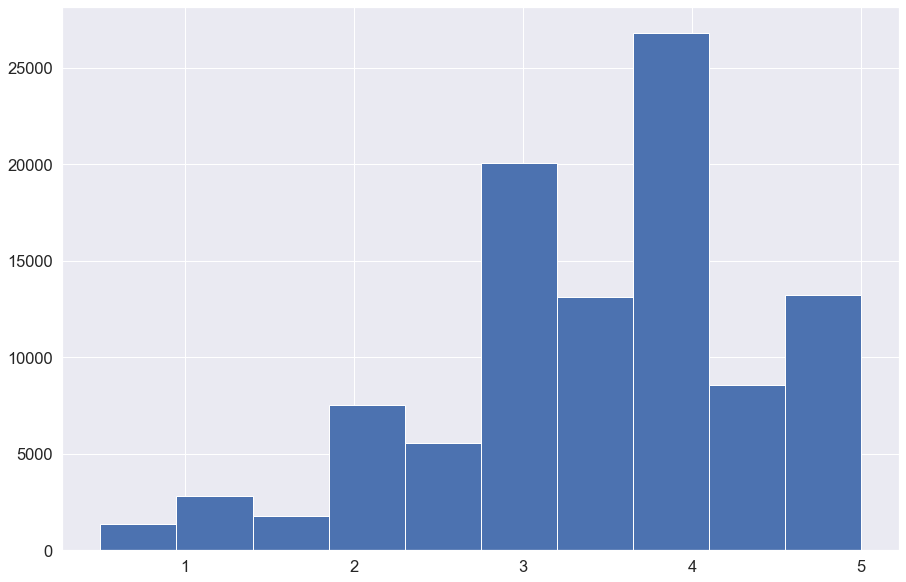

In [20]:
print(f"The mean rating: {ratings['rating'].mean()}")
fig, ax = plt.subplots(figsize = (15,10))

# Display distribution of rating
plt.hist(ratings['rating'])
plt.show();

It appears that users are quite generous in their ratings. The mean rating is 3.5 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skew wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average movie, whereas person B only gives 4 out for their favorites). Each user rated at least 20 movies, so I doubt the distribution could be caused just by chance variance in the quality of movies.

#### d. Tags data

In [27]:
print('Shape of this dataset :',tags.shape)
tags.head()

Shape of this dataset : (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### 4. Preprocessing

As the only features here are the ratings of other users and items, we need to keep everything together. To load a dataset from a pandas dataframe, I need the Reader and Dataset packages. Once data is loaded, it will be split into 80-20 proportion. 80% of the ratings are in the training set and 20% in the test set. 

In [28]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split

In [29]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

In [30]:
trainset, testset = train_test_split(data, test_size=0.2)

### 5. Collaborative Filtering Recommender

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. It can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative filtering. In this project, I'll use both approaches for my recommender system.

### 6. Memory-Based Methods (Neighborhood-Based)

In [31]:
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [32]:
print("Number of users: ", trainset.n_users, "\n")
print("Number of items: ", trainset.n_items, "\n")

Number of users:  610 

Number of items:  9011 



There are clearly way more items than users! We'll take that into account when inputting the specifications to our similarity metrics. Because we have fewer users than items, it will be more efficient to calculate user-user similarity rather than item-item similarity.

In [33]:
sim_cos = {"name": "cosine", "user_based": True}
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9790
0.9790216588939797


In [34]:
sim_pearson = {"name": "pearson", "user_based": True}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9798
0.9798476212466669


The Pearson correlation seems to have performed better than cosine similarity in the basic KNN model. Both model had RMSE of about 0.974, meaning that it was off by almost 1 point for each guess it made for ratings.

To further improve the neighborhood-based model, I will apply the KNNBaseline method, adding in bias term that is calculated by way of minimizing a cost function represented by:

$$ \sum_{r_{ui} \in R_{\text{train}}}{(\hat{r}_{ui} - ( \mu + b_{i} + b_{u}))^{2} + \lambda(b_u^2 + b_i^2) } $$

With $b_i$ and $b_u$ being biases for items and users respectively and $\mu$ referring to the global mean.

In [35]:
sim_pearson = {"name": "pearson", "user_based": False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8868
0.8868277121333226


Out of the three neighbor-based models, KNNBaseline method achieved the bestt RMSE. Here I will build a recommend function that takes in an user id and the list of predictions. Based on the predictions, it will suggest a list of movies that have highest predicted ratings to the user. 

In [77]:
def recommend(user_id, predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    l = list()
    for i in top_n[user_id]:
        l.append(movies[movies['movieId'] == i[0]].title.values[0])
    return l

In [78]:
# Print the 5 recommended items for user with id 275
rec = recommend(275, predictions)
rec

['Shawshank Redemption, The (1994)',
 "Ocean's Eleven (2001)",
 'American Beauty (1999)',
 'Maltese Falcon, The (1941)',
 'Toy Story (1995)']

### 7. Model-Based Methods (Matrix Factorization)

In [80]:
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

In [81]:
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)
predictions_SVD = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8868
0.8868277121333226
